In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("hls")

## Read Data

In [2]:
c_perp = pd.read_csv('perp_data/TRAIN_PATH_CPERPLEXITY.csv')
x_perp = pd.read_csv('perp_data/TRAIN_PATH_XPERPLEXITY.csv')
combine = pd.merge(c_perp,x_perp)

In [3]:
print('Nums of Training Example :',len(combine))

Nums of Training Example : 1281167


## X-Perplexity

#### Just plot the distribution of X_perplexity again. 

#### It is clear that the frequency of X_Perplexity is basically decrease monotonically with the increase of X_perplexity.

![](img/TRAIN_X_PERPLEXITY.png)

#### we want examples with higher perplexity have lower weights. Therefore, the designed weight function should have following property:

#### 1. the weight of examples shoule be monotonically decreasing with its X-perplexity

#### 2. The derivative of the weight function should also decrease monotonically.

$$f = b - c * exp(x) $$

#### For the weight, we want:

#### 1. The minimum weight should greater than zero

#### 2. The gap (maximum / minimum), should not be too larget, e.g. gap = 2. And we have b = gap * c * e

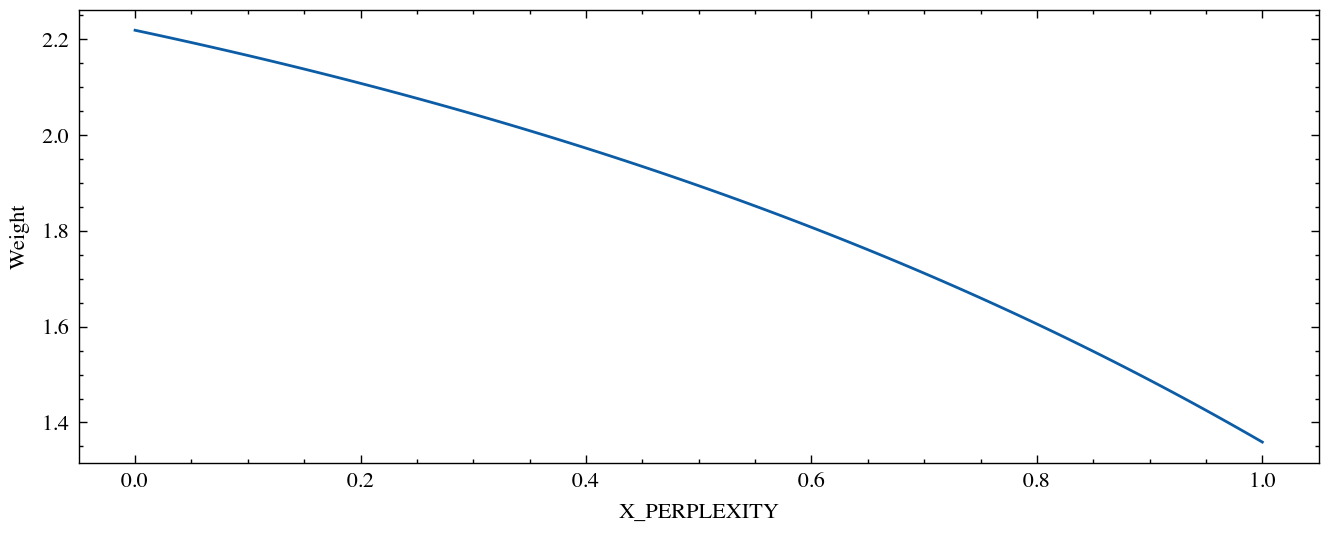

In [4]:
import math
def cal_x_weight(x):
    c = 0.5
    gap = 2
    b = gap*c*math.e
    return b - c*np.exp(x)
plt.style.use(['science','ieee','std-colors','no-latex'])
plt.figure(figsize=[8,3],dpi=200)
x = np.linspace(0,1,100)
plt.plot(x,cal_x_weight(x))
plt.xlabel('X_PERPLEXITY')
plt.ylabel('Weight')
combine['X_Weight'] = combine['X_PERPLEXITY'].apply(cal_x_weight)  

## C_PERPLEXITY

#### First, take a look of the distribution of C_PERPLEXITY

![](img/TRAIN_C_PERPLEXITY.png)

In [5]:
combine['C_PERPLEXITY'].describe()

count    1.281167e+06
mean     2.174600e+00
std      1.797890e+00
min      1.000000e+00
25%      1.149686e+00
50%      1.558888e+00
75%      2.427376e+00
max      5.175238e+01
Name: C_PERPLEXITY, dtype: float64

#### Thus, the range of C Perpelxity is quite different with X Perplexity, which is [1,52]. If we keep using the 
$$f = b - c * exp(x)$$ 

#### the weight of examples with extreme high C perplexity will be extreme small, which makes the contribution of examples with low C Perplexity extreme high,

#### just like we delete those examples. 

#### Therefore, we need to change the property of weights assignment function for C Perplexity :

#### 1. the weight of examples shoule be monotonically decreasing with its X-perplexity

#### 2. The derivative of the weight function should also decrease with C Perplexity when it is small and increase with C Perplexity when it is large.

#### Therefore, A sigmoid-like function can satisfy the property.

$$f = b - c*(1/(1+exp(x-\delta))))$$

#### Here, b is a Correction bias which makes the smallest weight to be 1; c is a Multiple factor to control the upper bound of the weight; $\delta$ is the Offset 
#### of x. when x < $\delta$, the derivative decrease; when x > $\delta$, the derivative increase.

count    1.281167e+06
mean     2.127618e+00
std      2.172797e-01
min      1.350000e+00
25%      2.134028e+00
50%      2.222502e+00
75%      2.247078e+00
max      2.254079e+00
Name: C_Weight, dtype: float64

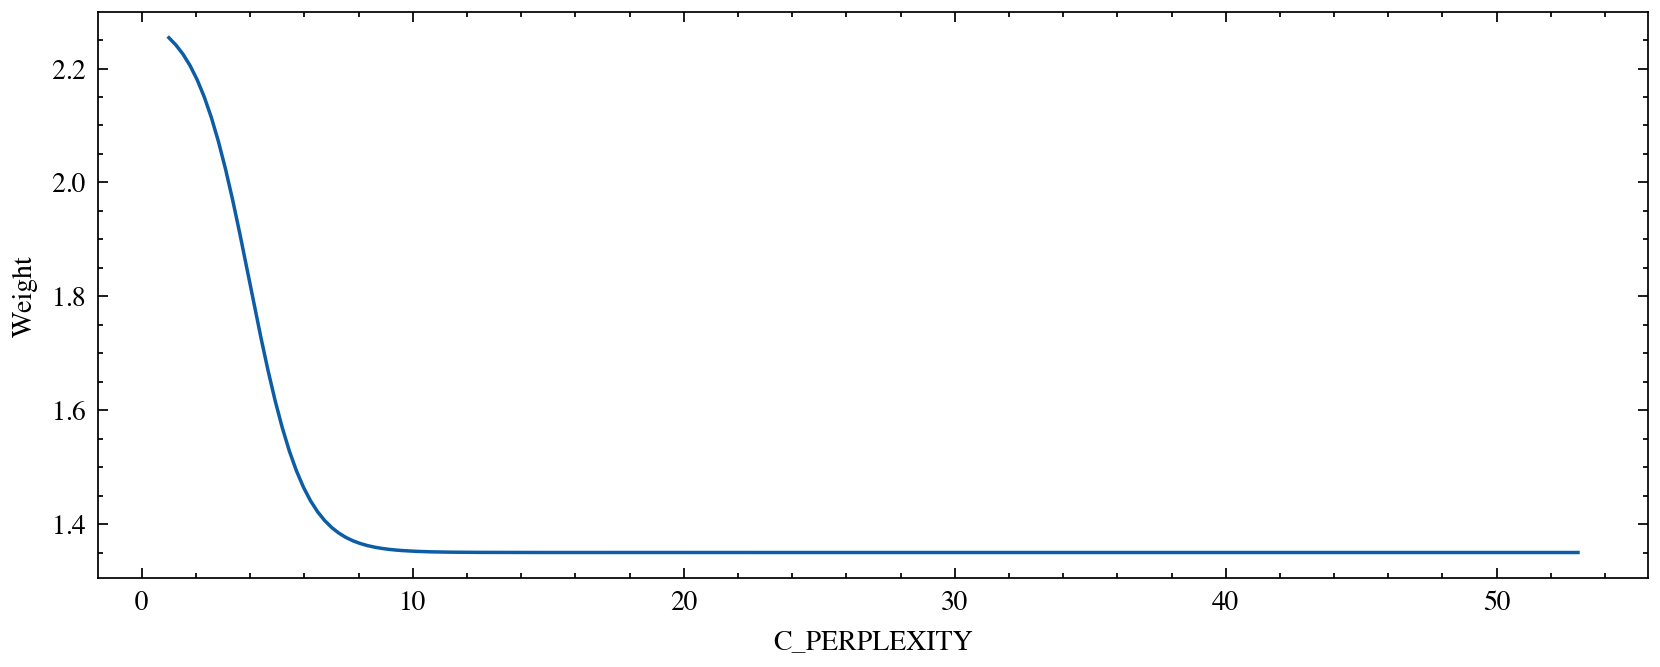

In [11]:
def cal_c_weight(x):
    b = 2.3
    c = 0.95
    delta = 3.98 #about 90% percentile of C perplexity
    return b - c*(1/(1+np.exp(-(x-delta))))
plt.style.use(['science','ieee','std-colors','no-latex'])
plt.figure(figsize=[8,3],dpi=250)
x = np.linspace(1,53,200)
plt.plot(x,cal_c_weight(x))
plt.xlabel('C_PERPLEXITY')
plt.ylabel('Weight')
combine['C_Weight'] = combine['C_PERPLEXITY'].apply(cal_c_weight)  
combine['C_Weight'].describe()

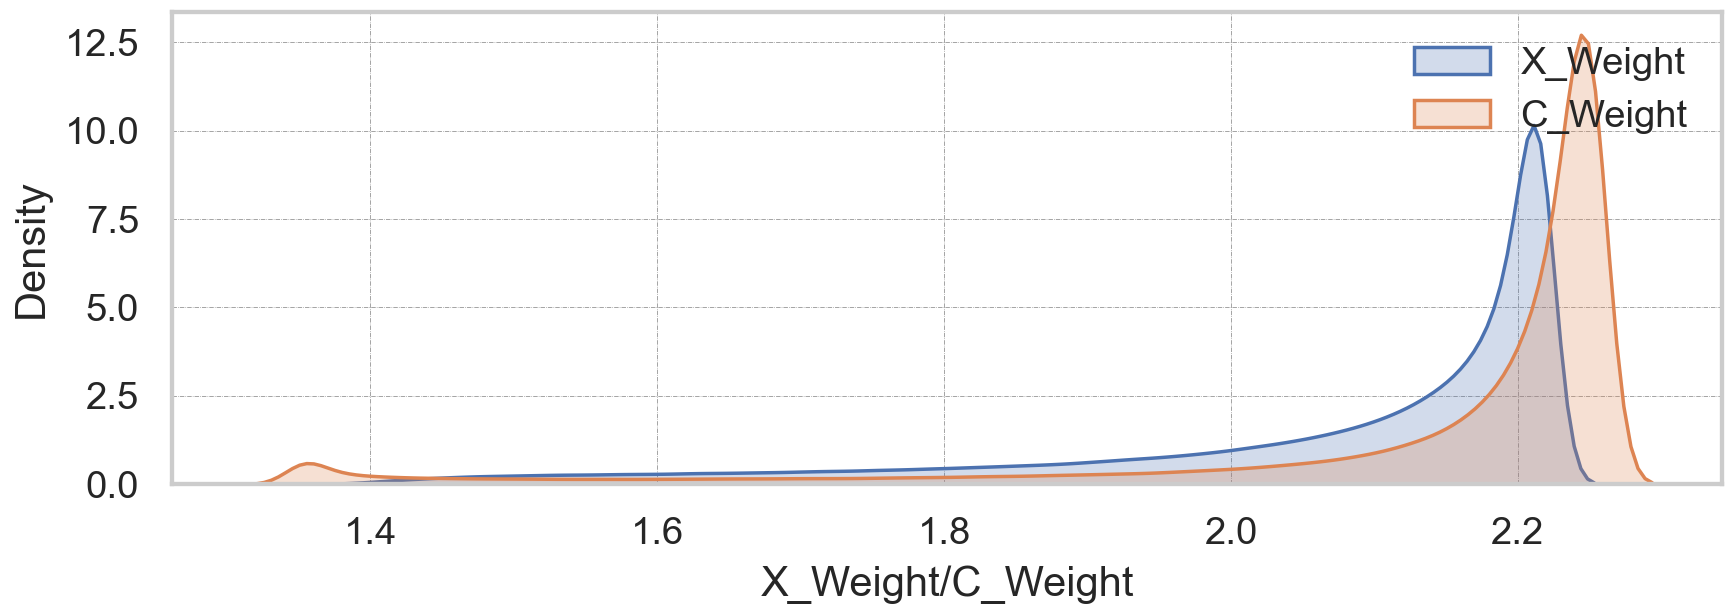

In [7]:
plt.style.use(['science','ieee','std-colors','no-latex'])
fig = plt.figure(figsize=[8,2.5],dpi=250)
fig.patch.set_facecolor('#FFFFFF')
sns.set_theme(style="whitegrid")
plt.grid(color='grey', linestyle='-.', linewidth=0.2)
sns.kdeplot(combine['X_Weight'],label = 'X_Weight',shade=True)
sns.kdeplot(combine['C_Weight'],label = 'C_Weight',shade=True)
plt.xlabel('X_Weight/C_Weight')
plt.legend()
plt.savefig('img/KDE_weight_low.png',dpi=250, facecolor=fig.get_facecolor(),bbox_inches='tight')

#### Export the weight to .csv file

In [8]:
mapper = pd.read_csv('data/id_label_map.csv')
id_label = dict(zip(mapper['ID'],mapper['Label']))
folder_id= dict(zip(mapper['Nums'],mapper['ID']))
def replace_path(x):
    return x.replace('./ILSVRC2012_img_train','/4tssd/imagenet/train')
def get_label(x):
    return x.split('/')[4]

In [9]:
combine['PATH'] = combine['PATH'].apply(replace_path)
combine['LABEL'] = combine['PATH'].apply(get_label)
combine = combine.sample(frac = 1) #shuffle the training data for training
combine.to_csv('data/WEIGHT_TRAINING_LOW.csv',index=None)